In [1]:
import os
import random
import time
import cv2
import numpy as np
import logging
import argparse
import os,sys,inspect
pwdpath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# sys.path.insert(0, pwdpath)
from pathlib import Path
sys.path.insert(0, str(Path(pwdpath).parent))
sys.path.insert(0, str(Path(pwdpath).parent / 'train'))

print(sys.path)

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.multiprocessing as mp
import torch.distributed as dist
from tensorboardX import SummaryWriter

from util import dataset, transform, config
from util.util import AverageMeter, poly_learning_rate, intersectionAndUnionGPU, find_free_port, colorize

cv2.ocl.setUseOpenCL(False)
cv2.setNumThreads(0)

from train import *

['/home/ruizhu/Documents/Projects/semseg/train', '/home/ruizhu/Documents/Projects/semseg', '/home/ruizhu/Documents/Projects/semseg/notebooks', '/home/ruizhu/anaconda3/envs/semseg/lib/python37.zip', '/home/ruizhu/anaconda3/envs/semseg/lib/python3.7', '/home/ruizhu/anaconda3/envs/semseg/lib/python3.7/lib-dynload', '', '/home/ruizhu/.local/lib/python3.7/site-packages', '/home/ruizhu/anaconda3/envs/semseg/lib/python3.7/site-packages', '/home/ruizhu/anaconda3/envs/semseg/lib/python3.7/site-packages/IPython/extensions', '/home/ruizhu/.ipython']


In [2]:
def get_parser(string):
    parser = argparse.ArgumentParser(description='PyTorch Semantic Segmentation')
    parser.add_argument('--config', type=str, default='config/ade20k/ade20k_pspnet50.yaml', help='config file')
    parser.add_argument('opts', help='see config/ade20k/ade20k_pspnet50.yaml for all options', default=None, nargs=argparse.REMAINDER)
    args = parser.parse_args(string.split())
    assert args.config is not None
    cfg = config.load_cfg_from_cfg_file(args.config)
    if args.opts is not None:
        cfg = config.merge_cfg_from_list(cfg, args.opts)
    return cfg

def main_process():
    return not args.multiprocessing_distributed or (args.multiprocessing_distributed and args.rank % args.ngpus_per_node == 0)

args = get_parser('--config ../train/config/openrooms/openrooms_pspnet50.yaml data_config_path ../train/data/ \
    batch_size_val 1 data_root ../dataset/openrooms data_config_path ../train/data project_path ../train/')
for key in ['train_list', 'val_list', 'colors_path', 'names_path']:
    args[key] = os.path.join(args.data_config_path, args[key])
for key in ['save_path', 'model_path', 'save_folder']:
    args[key] = os.path.join(args.project_path, args[key])
for key in ['save_path', 'model_path', 'save_folder']:
    args[key] = args[key] % args.exp_name
    
    

    


check(args)
args.train_gpu = [0]
args.multiprocessing_distributed = False
# args.initmodel_path = '../initmodel'

os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(x) for x in args.train_gpu)
if args.manual_seed is not None:
    random.seed(args.manual_seed)
    np.random.seed(args.manual_seed)
    torch.manual_seed(args.manual_seed)
    torch.cuda.manual_seed(args.manual_seed)
    torch.cuda.manual_seed_all(args.manual_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
if args.dist_url == "env://" and args.world_size == -1:
    args.world_size = int(os.environ["WORLD_SIZE"])
args.distributed = args.world_size > 1 or args.multiprocessing_distributed
args.ngpus_per_node = len(args.train_gpu)
if len(args.train_gpu) == 1:
    args.sync_bn = False
    args.distributed = False
    args.multiprocessing_distributed = False
# if args.multiprocessing_distributed:
#     port = find_free_port()
#     args.dist_url = f"tcp://127.0.0.1:{port}"
#     args.world_size = args.ngpus_per_node * args.world_size
#     mp.spawn(main_worker, nprocs=args.ngpus_per_node, args=(args.ngpus_per_node, args))
# else:
#     main_worker(args.train_gpu, args.ngpus_per_node, args)

{'PATHS': {'data_config_path': 'train/data', 'data_root': 'dataset/openrooms', 'project_path': '.', 'data_root_cluster': '/siggraphasia20dataset/code/Routine/DatasetCreation', 'project_path_cluster': '/viscompfs/users/ruizhu/semseg', 'exp_name': 'pspnet50'}, 'DATA': {'dataset_name': 'openrooms', 'train_list': 'openrooms/list/train.txt', 'val_list': 'openrooms/list/val.txt', 'classes': 44}, 'TRAIN': {'arch': 'psp', 'layers': 50, 'sync_bn': True, 'train_h': 241, 'train_w': 321, 'resize': True, 'resize_h': 240, 'resize_w': 320, 'scale_min': 0.5, 'scale_max': 2.0, 'rotate_min': -10, 'rotate_max': 10, 'zoom_factor': 8, 'ignore_label': 0, 'aux_weight': 0.4, 'train_gpu': [0, 1, 2, 3], 'workers': 16, 'batch_size': 32, 'batch_size_val': 32, 'base_lr': 0.01, 'epochs': 200, 'start_epoch': 0, 'power': 0.9, 'momentum': 0.9, 'weight_decay': 0.0001, 'manual_seed': None, 'print_freq': 10, 'save_freq': 1, 'save_path': 'exp/openrooms/%s/model', 'weight': None, 'resume': None, 'evaluate': True, 'val_ever

In [3]:
global args
if args.distributed:
    if args.dist_url == "env://" and args.rank == -1:
        args.rank = int(os.environ["RANK"])
    if args.multiprocessing_distributed:
        args.rank = args.rank * ngpus_per_node + gpu
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url, world_size=args.world_size, rank=args.rank)

criterion = nn.CrossEntropyLoss(ignore_index=args.ignore_label)
if args.arch == 'psp':
    from model.pspnet import PSPNet
    model = PSPNet(layers=args.layers, classes=args.classes, zoom_factor=args.zoom_factor, criterion=criterion, args=args)
    modules_ori = [model.layer0, model.layer1, model.layer2, model.layer3, model.layer4]
    modules_new = [model.ppm, model.cls, model.aux]
elif args.arch == 'psa':
    from model.psanet import PSANet
    model = PSANet(layers=args.layers, classes=args.classes, zoom_factor=args.zoom_factor, psa_type=args.psa_type,
                   compact=args.compact, shrink_factor=args.shrink_factor, mask_h=args.mask_h, mask_w=args.mask_w,
                   normalization_factor=args.normalization_factor, psa_softmax=args.psa_softmax, criterion=criterion)
    modules_ori = [model.layer0, model.layer1, model.layer2, model.layer3, model.layer4]
    modules_new = [model.psa, model.cls, model.aux]
params_list = []
for module in modules_ori:
    params_list.append(dict(params=module.parameters(), lr=args.base_lr))
for module in modules_new:
    params_list.append(dict(params=module.parameters(), lr=args.base_lr * 10))
args.index_split = 5
optimizer = torch.optim.SGD(params_list, lr=args.base_lr, momentum=args.momentum, weight_decay=args.weight_decay)
if args.sync_bn:
    model = nn.SyncBatchNorm.convert_sync_batchnorm(model)

if main_process():
    global logger, writer
    logger = get_logger()
    writer = SummaryWriter(args.save_path)
    logger.info(args)
    logger.info("=> creating model ...")
    logger.info("Classes: {}".format(args.classes))
    logger.info(model)
else:
    logger = None
if args.distributed:
    torch.cuda.set_device(gpu)
    args.batch_size = int(args.batch_size / ngpus_per_node)
    args.batch_size_val = int(args.batch_size_val / ngpus_per_node)
    args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
    model = torch.nn.parallel.DistributedDataParallel(model.cuda(), device_ids=[gpu])
else:
    model = torch.nn.DataParallel(model.cuda())

if args.weight:
    if os.path.isfile(args.weight):
        if main_process():
            logger.info("=> loading weight '{}'".format(args.weight))
        checkpoint = torch.load(args.weight)
        model.load_state_dict(checkpoint['state_dict'])
        if main_process():
            logger.info("=> loaded weight '{}'".format(args.weight))
    else:
        if main_process():
            logger.info("=> no weight found at '{}'".format(args.weight))

if args.resume:
    if os.path.isfile(args.resume):
        if main_process():
            logger.info("=> loading checkpoint '{}'".format(args.resume))
        # checkpoint = torch.load(args.resume)
        checkpoint = torch.load(args.resume, map_location=lambda storage, loc: storage.cuda())
        args.start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        if main_process():
            logger.info("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
    else:
        if main_process():
            logger.info("=> no checkpoint found at '{}'".format(args.resume))

value_scale = 255
mean = [0.485, 0.456, 0.406]
mean = [item * value_scale for item in mean]
std = [0.229, 0.224, 0.225]
std = [item * value_scale for item in std]

transform_list_train = []
if args.resize:
    transform_list_train.append(transform.Resize((args.resize_h, args.resize_w)))
transform_list_train += [
    transform.RandScale([args.scale_min, args.scale_max]),
    transform.RandRotate([args.rotate_min, args.rotate_max], padding=mean, ignore_label=args.ignore_label),
    transform.RandomGaussianBlur(),
    transform.RandomHorizontalFlip(),
    transform.Crop([args.train_h, args.train_w], crop_type='rand', padding=mean, ignore_label=args.ignore_label),
    transform.ToTensor(),
    transform.Normalize(mean=mean, std=std)
]
train_transform = transform.Compose(transform_list_train)
train_data = dataset.SemData(split='val', data_root=args.data_root, data_list=args.train_list, transform=train_transform, logger=logger, is_master=main_process(), args=args)
if args.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_data)
else:
    train_sampler = None
train_loader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size, shuffle=(train_sampler is None), num_workers=args.workers, pin_memory=True, sampler=train_sampler, drop_last=True)


if args.evaluate:
    transform_list_val = []
    if args.resize:
        transform_list_val.append(transform.Resize((args.resize_h, args.resize_w)))
    transform_list_val += [
        transform.Crop([args.train_h, args.train_w], crop_type='center', padding=mean, ignore_label=args.ignore_label),
        transform.ToTensor(),
        transform.Normalize(mean=mean, std=std)
        ]
    val_transform = transform.Compose(transform_list_val)
    val_data = dataset.SemData(split='val', data_root=args.data_root, data_list=args.val_list, transform=val_transform, is_master=main_process(), args=args)
    args.read_image = val_data.read_image
    if args.distributed:
        val_sampler = torch.utils.data.distributed.DistributedSampler(val_data)
    else:
        val_sampler = None
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=args.batch_size_val, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=val_sampler)


[2020-11-11 12:11:49,740 INFO <ipython-input-3-594e590f6c92> line 36 4629] arch: psp
aux_weight: 0.4
base_lr: 0.01
base_size: 2048
batch_size: 32
batch_size_val: 1
classes: 44
colors_path: ../train/data/openrooms/openrooms_colors.txt
data_config_path: ../train/data
data_root: ../dataset/openrooms
data_root_cluster: /siggraphasia20dataset/code/Routine/DatasetCreation
dataset_name: openrooms
dist_backend: nccl
dist_url: tcp://127.0.0.1:6789
distributed: False
epochs: 200
evaluate: True
exp_name: pspnet50
has_prediction: False
if_cluster: False
ignore_label: 0
index_split: 5
index_start: 0
index_step: 0
layers: 50
manual_seed: None
model_path: ../train/exp/openrooms/pspnet50/model/train_epoch_200.pth
momentum: 0.9
multiprocessing_distributed: False
names_path: ../train/data/openrooms/openrooms_names.txt
ngpus_per_node: 1
power: 0.9
print_freq: 10
project_path: ../train/
project_path_cluster: /viscompfs/users/ruizhu/semseg
rank: 0
resize: True
resize_h: 240
resize_w: 320
resume: None
rotat

Totally 102489 samples in val set.
Starting Checking image&label pair val list...
Checking image&label pair val list done!
Totally 5664 samples in val set.
Starting Checking image&label pair val list...
Checking image&label pair val list done!


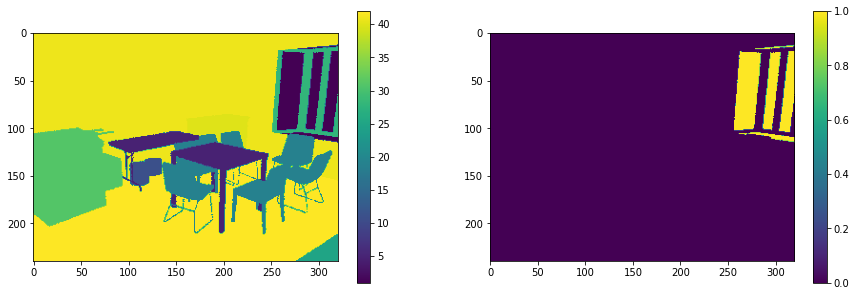

3 3803


In [13]:
model.eval()
for i, (input, target, image_paths) in enumerate(val_loader):
#     print(image_paths)
#     print(target.shape)
    if i != 3:
        continue
    label = target.cpu().numpy().squeeze()
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))
    label = label[:240, :320]
    plt.subplot(121)
    plt.imshow(label)
    plt.colorbar()
    plt.subplot(122)
    check_mask = label==1
    plt.imshow(check_mask)
    plt.colorbar()
    plt.show()
    
    print(i, np.sum(check_mask))
#     if i > 30:
#         break
    break

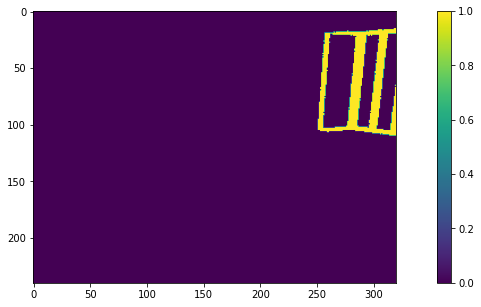

In [14]:
plt.figure(figsize=(15, 5))
check_mask = label==28
plt.imshow(check_mask)
plt.colorbar()
plt.show()